# Previsão de Engajamento - Classificação

Este notebook define modelos e hiperparâmetros e executa um validação cruzada aninhada com grid search para otimização de hiperparâmetros e treinamento.

- Entrada: `full-preproc2-inputs_(NOME_DO_MODELO)_(REDE_SOCIAL)` 
e `full-preproc2-outputs_(NOME_DO_MODELO)_(REDE_SOCIAL)`
- Saída: `resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}_(NOME_DO_MODELO)_(REDE_SOCIAL).npy`


In [1]:
#@title Importações de pacote
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
BASE_PATH = 'dados/preprocessed/'
MODEL_NAME = 'mxbai-embed-large-v1'
SOCIAL_NETWORK = 'tiktok'

# 1 - Carregando os Dados

Carregando dados brutos gerais.

In [3]:
dfx = pd.read_excel(f"{BASE_PATH}full-preproc2-inputs_{MODEL_NAME}_{SOCIAL_NETWORK}.xlsx", index_col='ID')
dfx.drop(columns=["Only Hashtags"],inplace=True)
dfx.head()

,Candidato_Bolsonaro,Candidato_Lula,Dias Decorridos,x1,x2,x3,x4,x5,x6,x7,...,x1015,x1016,x1017,x1018,x1019,x1020,x1021,x1022,x1023,x1024
ID,,,,,,,,,,,,,,,,,,,,,
7115033431473474822,0,1,94,-0.136752,-0.004471,-0.197404,0.771875,0.271732,-0.831048,0.572798,...,0.991231,-0.179094,0.009374,-0.510456,0.732227,-0.253170,0.185578,0.151233,-0.443790,-0.479070
7115174031162215686,0,1,94,-0.202921,0.046833,-0.182256,0.666116,0.354371,-0.201803,0.526789,...,1.219669,-0.223046,-0.214730,-0.466289,0.785575,-0.121878,0.218252,0.497084,-0.662330,0.082123
7115357413712153861,0,1,93,0.029744,0.393452,-0.301938,0.995043,-0.297031,-0.431491,1.016083,...,0.703671,0.198557,-0.226507,-0.561226,0.717053,0.401612,-0.630034,-0.050426,-0.719983,-0.286128
7115560675824422149,0,1,93,-0.185425,0.782692,-0.086695,0.831251,0.337393,-0.693311,0.471492,...,0.841613,-0.037051,-0.316676,-0.510069,0.825399,0.095525,-0.296313,0.055677,-0.575535,-0.053547
7115793869152734470,0,1,92,0.068613,-0.065852,-0.359612,0.638832,-0.074697,-0.239683,0.304781,...,0.919486,0.173887,-0.563785,-0.028777,0.640279,0.146346,-0.096667,0.012495,-0.735688,-0.274756


In [4]:
dfy_full = pd.read_excel(f"{BASE_PATH}full-preproc2-outputs_{MODEL_NAME}_{SOCIAL_NETWORK}.xlsx", index_col='ID')
dfy_full.head()

,Curtidas,Curtidas-Log,Curtidas-MinMax,Curtidas-Log-MinMax,Curtidas-2Classes-50p
ID,,,,,
7115033431473474822,11700,4.068186,0.005881,0.278511,0
7115174031162215686,33600,4.526339,0.018777,0.431384,1
7115357413712153861,34600,4.539076,0.019365,0.435634,1
7115560675824422149,47500,4.676694,0.026961,0.481554,1
7115793869152734470,22400,4.350248,0.012182,0.372628,1


## 1.1 - Escolha do Dataset (ALTERE)

In [5]:
from util import filter_dataset

# 'geral', 'lula' ou 'bolsonaro'
SUB_DATASET = 'lula'

TARGET_COL = 'Curtidas-2Classes-50p'

In [6]:
dfx, dfy = filter_dataset(dfx, dfy_full, SUB_DATASET, TARGET_COL)

Dataset LULA (indicador 1)


In [7]:
dfx.columns
dfx.shape

(308, 1025)

In [8]:

dfy.head()
#dfy.shape

ID
7115033431473474822    0
7115174031162215686    1
7115357413712153861    1
7115560675824422149    1
7115793869152734470    1
Name: Curtidas-2Classes-50p, dtype: int64

## 1.2 - Informações do Treinamento (ALTERE)

In [9]:
from datetime import datetime

RANDOM_STATE = 1231

START_DATE_STR = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")
#print(start_date_str)

metadata = dict()
metadata['date'] = START_DATE_STR
metadata['subdataset'] = SUB_DATASET
metadata['target'] = TARGET_COL
metadata['random_state'] = RANDOM_STATE

metadata['description'] =  f'''Treinamento com modelos com os 
dados balanceados (50p), com o dataset {SUB_DATASET}, com todos os modelos 
e com os novos ENSEMBLE *sem* data leakage, com a correção de escala para a MLP,
variando class_weight para os modelos que suportam'''

# 2 - Modelos

In [10]:
from sklearn.pipeline import Pipeline
from data_transformations_util import IdentityTransformer

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [12]:
lista_modelos = [
    {
        "nome_do_modelo": 'MLP Neural Network',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', MLPClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__hidden_layer_sizes': [(256,), (512,), (1024,)],  # Number of neurons in the hidden layer
            'predictor__learning_rate_init': [0.001, 0.01, 0.05],        # Learning rate
        }
    },
    {
        "nome_do_modelo": 'Support Vector Machine',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', SVC(random_state=42))   #SVC(probability=True) # muito lento?  Tempo médio de treinamento sem proba: 21.55 segundos / com proba: 35.11 segundos
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.1, 1.0, 10.0, 20.0, 50.0],
            'predictor__gamma': ['scale', 'auto'],
            'predictor__kernel': ['rbf', 'sigmoid','linear']
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('predictor', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'predictor__n_estimators': [10, 30, 70], 
            'predictor__class_weight': ['balanced', None], 
            'predictor__max_depth': [3, 4, 5, None],
            'predictor__min_samples_split': [2, 4, 8]
        }
    },
    {
        "nome_do_modelo": 'Logistic Regression',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', LogisticRegression(solver='saga', random_state=42))   # Saga is the only solver to support the 3 options for 'penalty'
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.01, 0.1, 1.0, 2.0],         # Regularization parameter
            'predictor__penalty': ['l1', 'l2', None]       # Penalty term
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('pca', PCA),
            ('scaler', StandardScaler()), 
            ('predictor', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__n_neighbors': [5, 10, 15, 20], 
            'predictor__weights': ['uniform', 'distance'], 
            'predictor__p': [1, 2]
        }
    },

]

In [13]:
BASIC_MODEL_NAMES = [ mdl["nome_do_modelo"] for mdl in lista_modelos ]
metadata['basic_models'] = BASIC_MODEL_NAMES

BASIC_MODEL_NAMES

['MLP Neural Network',
 'Support Vector Machine',
 'Random Forest',
 'Logistic Regression',
 'KNN']

# 3 - Treinamento

In [14]:
from classification_train_util import nested_cross_validation_grid_search

A linha abaixo executa nested cross-validation, com um grid search nos *inner folds*, para cada modelo.




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

Treinando modelo MLP Neural Network .

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\en

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\en

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\en

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\en

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\en

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\en


-- coletando e armazenando resultados --

 - Acurácia   : 0.5001 +/- 0.03444
 - Precisão   : 0.4483 +/- 0.23716
 - Revocação  : 0.3335 +/- 0.32737
 - F1 - Score : 0.3079 +/- 0.24321
 - ROC - AUC  : 0.5230 +/- 0.05521
 - PR - AUC   : 0.5557 +/- 0.05224
 - Tempo médio de treinamento: 82.88 segundos


Treinando modelo Support Vector Machine ..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


...

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


.
-- coletando e armazenando resultados --

 - Acurácia   : 0.4968 +/- 0.01713
 - Precisão   : 0.3302 +/- 0.23400
 - Revocação  : 0.5261 +/- 0.41647
 - F1 - Score : 0.3974 +/- 0.28902
 - ROC - AUC  : 0.4943 +/- 0.04031
 - PR - AUC   : 0.5114 +/- 0.03130
 - Tempo médio de treinamento: 193.20 segundos


Treinando modelo Random Forest ......
-- coletando e armazenando resultados --

 - Acurácia   : 0.4952 +/- 0.03956
 - Precisão   : 0.4977 +/- 0.03573
 - Revocação  : 0.4965 +/- 0.06868
 - F1 - Score : 0.4941 +/- 0.04107
 - ROC - AUC  : 0.5123 +/- 0.04156
 - PR - AUC   : 0.5287 +/- 0.03911
 - Tempo médio de treinamento: 82.34 segundos


Treinando modelo Logistic Regression .

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\s

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\s

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\s

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\s

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\s

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\s


-- coletando e armazenando resultados --

 - Acurácia   : 0.4984 +/- 0.02360
 - Precisão   : 0.4997 +/- 0.02632
 - Revocação  : 0.6172 +/- 0.18884
 - F1 - Score : 0.5408 +/- 0.06813
 - ROC - AUC  : 0.5248 +/- 0.02513
 - PR - AUC   : 0.5465 +/- 0.04661
 - Tempo médio de treinamento: 30.47 segundos


Treinando modelo KNN ......
-- coletando e armazenando resultados --

 - Acurácia   : 0.5260 +/- 0.04390
 - Precisão   : 0.5259 +/- 0.04795
 - Revocação  : 0.5258 +/- 0.07243
 - F1 - Score : 0.5242 +/- 0.05507
 - ROC - AUC  : 0.5415 +/- 0.05362
 - PR - AUC   : 0.5507 +/- 0.04230
 - Tempo médio de treinamento: 21.52 segundos


Terminado em 02/04/2025 14:29:21


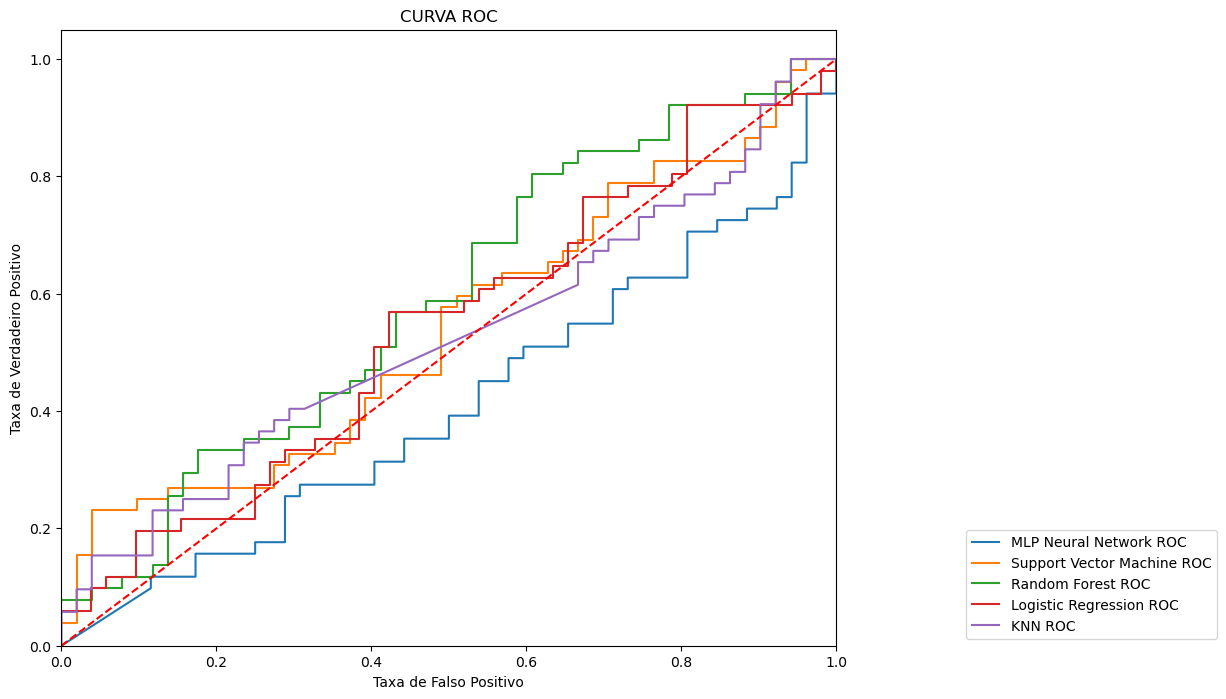

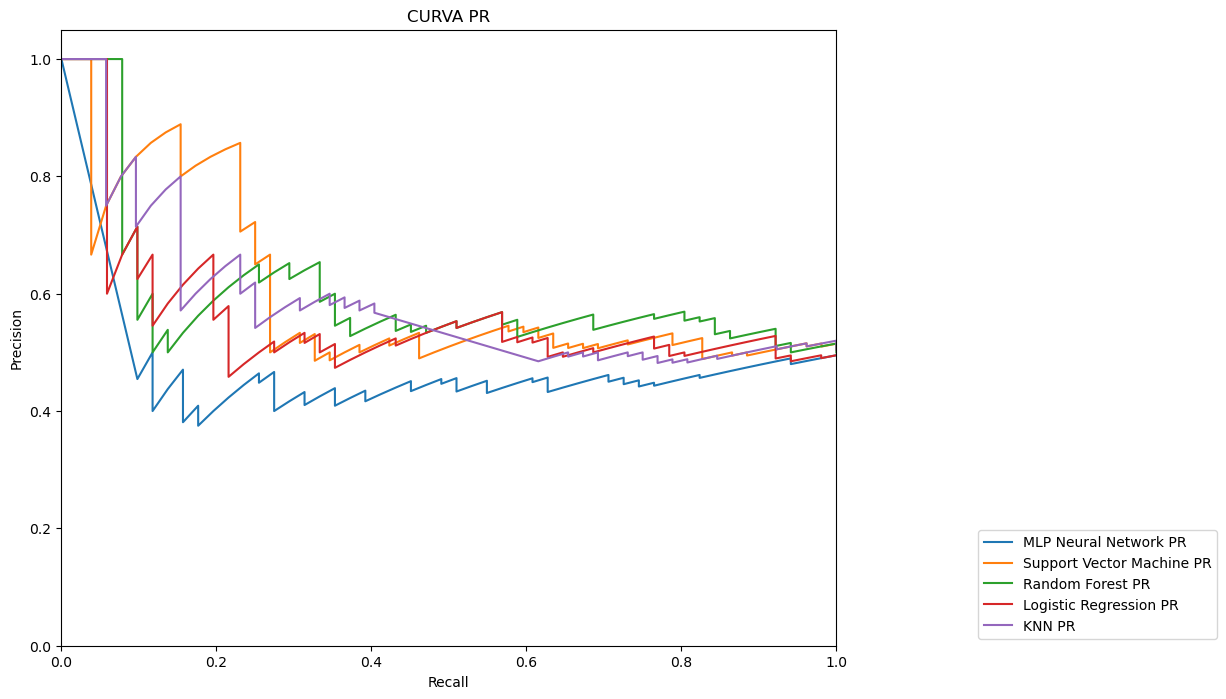

In [15]:
outer_folds = 3 #5
inner_folds = 3 #5
outer_folds_repetitions = 2 #1

last_run_basic = nested_cross_validation_grid_search(
    lista_modelos, 
    dfx, 
    dfy, 
    k_folds_outer=outer_folds,
    k_folds_inner=inner_folds,
    repetitions=outer_folds_repetitions,
    rand_state=RANDOM_STATE)


## 3.3 - Treina Ensembles (não foi publicado)

In [16]:
from copy import deepcopy

from ensemble_train_util import extract_all_best_models, extract_best_models_of_fold
from ensemble_train_util import train_ensemble

In [17]:
last_run_all = deepcopy(last_run_basic)

In [ ]:
total_outer_folds = (outer_folds * outer_folds_repetitions)

for fold_i in range(total_outer_folds):
    models = extract_best_models_of_fold(last_run_basic, fold_i)
    results_ensemble = train_ensemble(models, dfx, dfy, name_prefix=f"FOLD_{fold_i}") 
    
    # check if keys have no intersection (no common key), then merge results
    assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0
    last_run_all.update(results_ensemble)


.....................

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


......................

In [19]:
# Atenção: tem data leakage! Ver explicação na célula abaixo. Mantive apenas para comparação!

# Treina 2 ensemble mistos (versões hard e soft), usando o modelo obtido em cada fold externo (o modelo pode ser de qualquer tipo)
models = extract_all_best_models(last_run_basic)
results_ensemble = train_ensemble(models, dfx, dfy, name_prefix="Best") 

# check if keys have no intersection (no common key), then merge results
assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0
last_run_all.update(results_ensemble)

..........

In [21]:
#'''
# Atenção: Tem data leakage! 
# Explicação:
# - modelos escolhidas com base em diferentes folds 
# - assim, o ensemble se baseia em todo o dataset

from ensemble_train_util import extract_best_models_of_type

models_list = ['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN']

for model_name in BASIC_MODEL_NAMES:
    print(f"\n\n\n **** TREINANDO ENSEMBLE PARA {model_name} ****\n")
    contracted_name = ''.join([name[0] for name in model_name.split()])
    models = extract_best_models_of_type(last_run_all, model_name)
    results_ensemble = train_ensemble(models, dfx, dfy, name_prefix=contracted_name)

    # check if keys have no intersection (no common key), then merge results
    assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0
    last_run_all.update(results_ensemble)

#'''




 **** TREINANDO ENSEMBLE PARA MLP Neural Network ****

..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


..


 **** TREINANDO ENSEMBLE PARA Support Vector Machine ****

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


.........


 **** TREINANDO ENSEMBLE PARA Random Forest ****

..........


 **** TREINANDO ENSEMBLE PARA Logistic Regression ****

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(





 **** TREINANDO ENSEMBLE PARA KNN ****

..........

## 3.4 - Salva Resultados

In [22]:
from util import save_results

In [23]:
last_run_all.keys()

dict_keys(['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN', 'FOLD_0-hard-vote', 'FOLD_0-soft-vote', 'FOLD_1-hard-vote', 'FOLD_1-soft-vote', 'FOLD_2-hard-vote', 'FOLD_2-soft-vote', 'FOLD_3-hard-vote', 'FOLD_3-soft-vote', 'FOLD_4-hard-vote', 'FOLD_4-soft-vote', 'FOLD_5-hard-vote', 'FOLD_5-soft-vote', 'Best-hard-vote', 'Best-soft-vote', 'MNN-hard-vote', 'MNN-soft-vote', 'SVM-hard-vote', 'SVM-soft-vote', 'RF-hard-vote', 'RF-soft-vote', 'LR-hard-vote', 'LR-soft-vote', 'K-hard-vote', 'K-soft-vote'])

In [ ]:
#last_run_basic['KNN']

{'Acurácia_mean': 0.5260168792436067,
 'Acurácia_std': 0.04390492750566338,
 'Precisão_mean': 0.5258925335675538,
 'Precisão_std': 0.04795288066946167,
 'Revocação_mean': 0.5257667169431874,
 'Revocação_std': 0.07243276871705362,
 'F1_score_mean': 0.5242151263866819,
 'F1_score_std': 0.05507291374684449,
 'aucROC_mean': 0.541479361981092,
 'aucROC_std': 0.053622700458746814,
 'aucPR_mean': 0.5507329184133961,
 'aucPR_std': 0.042295118331445815,
 'tempo_medio_treinamento': 21.521265467007954,
 'F1_score_list': [0.43010752688172044,
  0.5656565656565656,
  0.5871559633027523,
  0.48148148148148145,
  0.5660377358490566,
  0.5148514851485149],
 'melhores_parametros': [{'pca': PCA(n_components=20),
   'predictor__n_neighbors': 5,
   'predictor__p': 2,
   'predictor__weights': 'distance',
   'scaler': MinMaxScaler()},
  {'pca': PCA(n_components=30),
   'predictor__n_neighbors': 15,
   'predictor__p': 2,
   'predictor__weights': 'distance',
   'scaler': MinMaxScaler()},
  {'pca': PCA(n_compo

In [26]:
OUTPUT_FILE_PATH = f'resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}({MODEL_NAME})_({SOCIAL_NETWORK}).npy'

save_results(OUTPUT_FILE_PATH, last_run_all, metadata)

print("Arquivo salvo:", OUTPUT_FILE_PATH)

Arquivo salvo: resultados/resultados50p_2025-04-02-13h48m_lula(mxbai-embed-large-v1)_(tiktok).npy


----

# FIM